Ok, we have a comparison between HAT & Kepler based just on data volume.

# What about their relative _precision_? 
Stick to the metric of "binned to 1 hour, what is the standard deviation of an intrinsically constant source?"

Compare HAT vs TESS vs Kepler.

In [1]:
from IPython.display import Image

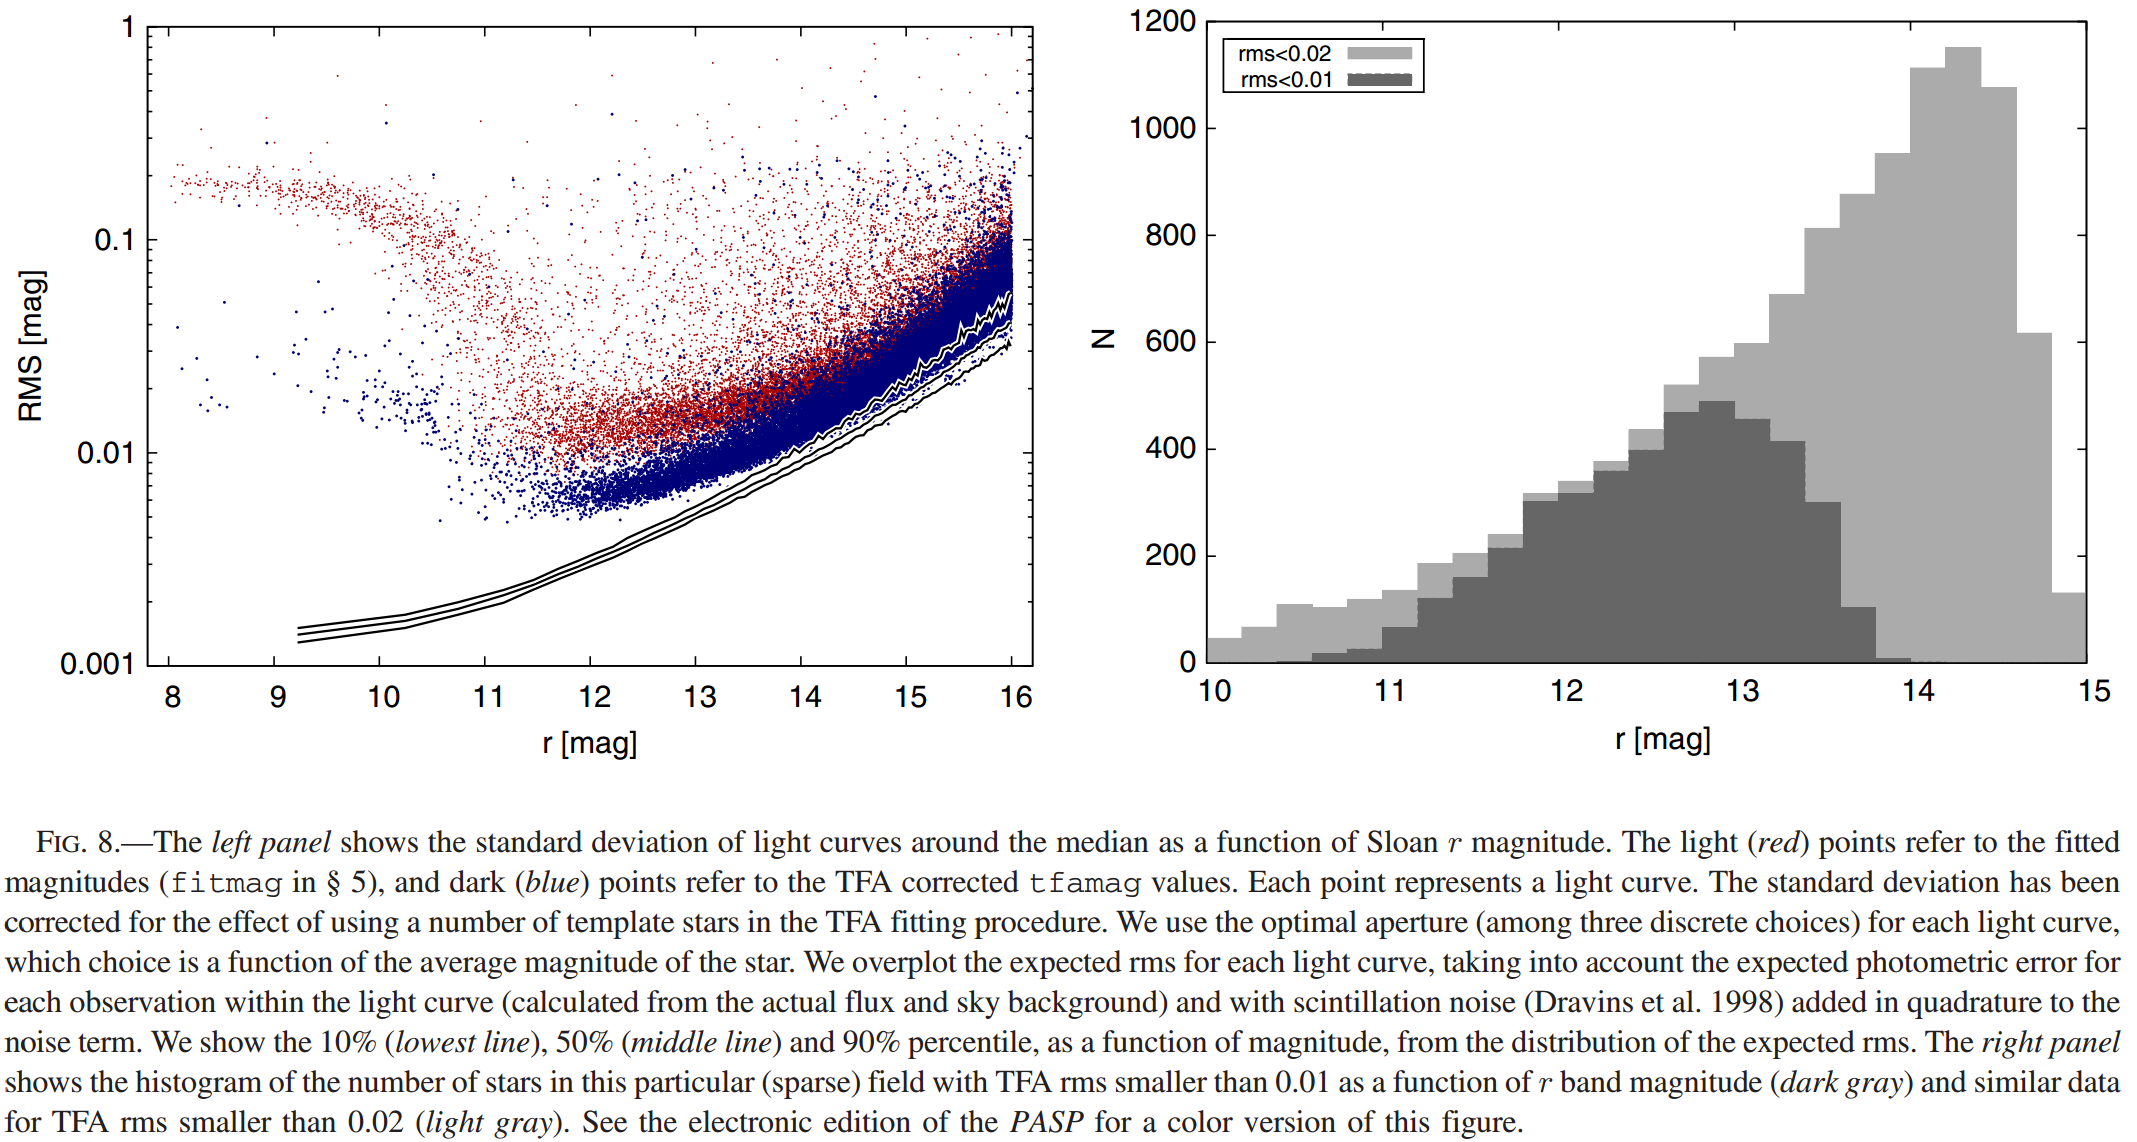

In [2]:
Image('../../hat/doc/HAT_precision.png')

I'm confused. In the above plot, what is the timescale for "RMS [mag]" in the LHS plot?

I think it's the ~5.5 minute cadence used for most of the HAT observations (e.g., Hartman, Bakos, Kovacs and Noyes 2010), and calculated as:

\begin{equation}
\mathrm{rms} = \sqrt{\frac{\sum(m_i - \langle m \rangle)^2}{N-N_p}},
\end{equation}
"for $m_i$ the individual magnitudes, $\langle m \rangle$ the average magnitude, $N$ the number of the points in the LC, and the $N_p=544$ the number of parameters used in applying EPD/TFA."

In [3]:
ls

debinfo_170129.csv       kepler_precision.pdf   plots/
hat_eb_catalog.ipynb     lightcurve-work.ipynb  precision_comparison.ipynb
kepler_eb_catalog.ipynb  nb-data/


In [4]:
ls nb-data/

checkplot-HAT-199-0000452.pkl
checkplot-HAT-199-0000452.png
checkplot-inj-HAT-199-0000452.pkl
checkplot-inj-HAT-199-0000452.png
checkplot-injresiduals-HAT-199-0000452.pkl
HAT-579-0051858-V0-DR0-e867e20a15f25116548f6cdf8d5105f2-hatlc.csv
HAT-772-0554686-V0-DR0-hatlc.sqlite
HAT-777-0058978-V0-DR0-hatlc.sqlite
kepler_and_johnson_bandpasses.jpg
kepler_precision.csv
plots/


In [5]:
import pickle
pklpath = 'nb-data/checkplot-HAT-199-0000452.pkl'
thislc = pickle.load(open(pklpath, 'rb'))

In [6]:
thislc.keys()

dict_keys(['varinfo', 'bls', 'sigclip', 'objectid', 'finderchart', 'status', 'normto', 'normmingap', 'pdm', 'objectinfo', 'magseries'])

In [7]:
thislc['objectinfo']

{'bmag': 8.869,
 'bvcolor': 0.3439999999999994,
 'decl': 33.800232,
 'hatid': 'HAT-199-0000452',
 'hmag': 7.637,
 'ijcolor': None,
 'jkcolor': 0.17499999999999982,
 'jmag': 7.768,
 'kmag': 7.593,
 'ndet': 4351,
 'network': 'HN',
 'objecttags': None,
 'pmdecl': 11.7,
 'pmdecl_err': 1.0,
 'pmra': 1.6,
 'pmra_err': 1.0,
 'propermotion': 11.77530298964736,
 'ra': 292.935637,
 'reducedpropermotion': -1.8771395462441722,
 'sdssg': None,
 'sdssi': None,
 'sdssr': None,
 'stations': 'HN05,HN08',
 'twomassid': '19314455+3348008 ',
 'ucac4id': '146114592',
 'vmag': 8.525}

In [8]:
import numpy as np

In [9]:
thislc['magseries'].keys()

dict_keys(['times', 'plot', 'mags', 'errs'])

In [10]:
meanmag = np.mean(thislc['magseries']['mags'])
mags = thislc['magseries']['mags']
N_p = 544
N = thislc['objectinfo']['ndet']
rms = np.sqrt(np.sum( (mags - meanmag)**2) / (N - N_p))
rms

0.020000284232309356

Hartman et al. (2010) use the following to convert btwn 2MASS and Sloan magnitudes:
\begin{equation}
r = 0.6975 + 2.9782J − 0.8809H − 1.1230K_S.
\end{equation}

In [11]:
if thislc['objectinfo']['sdssr']:
    rmag = thislc['objectinfo']['sdssr']
elif thislc['objectinfo']['jmag'] and thislc['objectinfo']['hmag'] and thislc['objectinfo']['kmag']:
    rmag = 0.6975 + 2.9782 * thislc['objectinfo']['jmag'] - 0.8809 * thislc['objectinfo']['hmag'] - 1.1230 * thislc['objectinfo']['kmag']
else:
    rmag = -99

In [12]:
rmag

8.5777853

So what we _want_ is a histogram of the RMS precision for HAT LCs (in the DEB sample).
And a histogram of the RMS precison of Kepler Eclipsing Binary Catalog LCs.

Additionally, we want histograms of the _observed magnitudes_.

Additionally, we want a plot that compares (even if roughly) the precision as a function of magnitude for Kepler vs TESS vs HAT.

(N.b. this might be another selling point of the HAT LCs for an EB catalog: they are **brighter**)

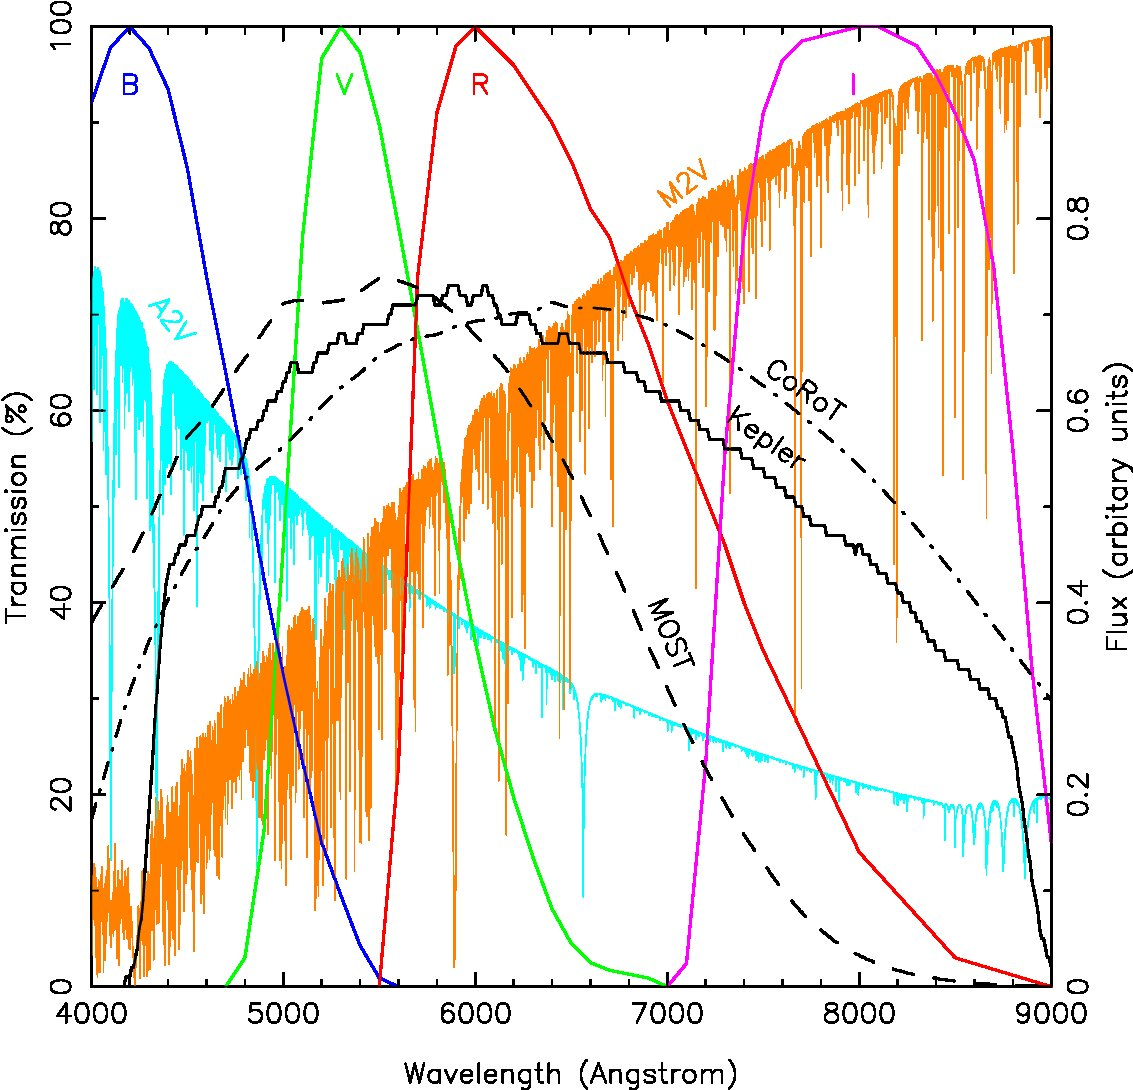

In [13]:
Image('nb-data/kepler_and_johnson_bandpasses.jpg')

Ok, so it's not crazy to say "Kepler magnitudes are ~give or take the same as Johnson's R" (which is what's plotted). N.b. SDSS r, which is what HAT uses, is ~550-700nm. Yes, this is the peak of the Kepler curve, but Kepler is OFC very sensitive to M dwarfs that HAT is very _insensitive_ to, b/c they're so faint in SDSS r.

In [14]:
# %load ../../hat/src/04_make_DEB_catalog.py
import os
import itertools
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle


def get_DEB_list():
    '''
    After looking at and flagging DEBs, get a list of them.
    Also get properties of the stars -- their RMS and SDSS r magnitudes.
    '''

    with open('../../hat/src/04_DATA_processed_fields.txt') as f:
        fieldstrs = f.readlines()

    fieldstrs = [f.strip('\n') for f in fieldstrs]

    debpaths = []
    deblengths, debperiods, debrmss, debrmags = [], [], [], []
    weirdpaths = []
    allpaths = []
    for fieldstr in fieldstrs:
        #FIXME: be smarter about where checkplot data is stored
        cppath = '/media/luke/LGB_tess_data/hat/CPs_cut/G'+fieldstr+'_20'
        #cppath = '../data/CPs_cut/G'+fieldstr+'_20'
        pklpaths = [cppath+'/'+f for f in os.listdir(cppath) if f.endswith('.pkl')]
        allpaths.append(pklpaths)

        for ix, pklpath in enumerate(pklpaths):
            if ix % 100 == 0:
                print('{:d} of {:d}'.format(ix, len(pklpaths)))

            thislc = pickle.load(open(pklpath, 'rb'))

            if thislc['varinfo']['vartags'] == 'detached EB':
                debpaths.append(pklpath)
                deblengths.append(len(thislc['magseries']['times']))
                debperiods.append(thislc['varinfo']['varperiod'])

                #follow Hartman et al. (2010) Eq 2 to calculate unbiased rms.
                meanmag = np.mean(thislc['magseries']['mags'])
                mags = thislc['magseries']['mags']
                N_p = 544
                N = thislc['objectinfo']['ndet']
                if N > N_p:
                    rms = np.sqrt(np.sum( (mags - meanmag)**2) / (N - N_p))
                else:
                    rms = -99
                debrmss.append(rms)

                #transform from 2MASS to Sloan r following Hartman+ 2010 Eq 1.
                if thislc['objectinfo']['sdssr']:
                    rmag = thislc['objectinfo']['sdssr']

                elif thislc['objectinfo']['jmag'] and \
                        thislc['objectinfo']['hmag'] and \
                        thislc['objectinfo']['kmag']:

                    rmag = 0.6975 + 2.9782 * thislc['objectinfo']['jmag'] \
                            - 0.8809 * thislc['objectinfo']['hmag'] \
                            - 1.1230 * thislc['objectinfo']['kmag']

                else:
                    rmag = -99

                debrmags.append(rmag)



            elif thislc['varinfo']['vartags'] == 'weird variability':
                weirdpaths.append(pklpath)


        print('{:s} retrieved.'.format(fieldstr))

    allpaths = list(itertools.chain.from_iterable(allpaths))

    return debpaths, weirdpaths, allpaths, deblengths, debperiods, \
            debrmss, debrmags



def print_list_summaries(debpaths, weirdpaths, allpaths):

    pathd = {'debs':debpaths, 'weirds':weirdpaths, 'all':allpaths}
    for k in pathd.keys():
        print('{:s}: length {:d}, fraction {:.3g}'.format(\
                k, len(pathd[k]), len(pathd[k])/len(pathd['all'])))

def get_DEB_ids(debpaths):
    '''
    Given debpaths, parse it into a list of dictionaries where each dictionary
    gets: hatid (str), pickle path (str), original LC path (for sigma clipping
    reversion).
    '''



if __name__ == '__main__':

    debpaths, weirdpaths, allpaths, deblengths, debperiods, \
            debrmss, debrmags = get_DEB_list()
    print_list_summaries(debpaths, weirdpaths, allpaths)



0 of 58
088 retrieved.
0 of 479
100 of 479
200 of 479
300 of 479
400 of 479
081 retrieved.
0 of 208
100 of 208
200 of 208
133 retrieved.
0 of 217
100 of 217
200 of 217
248 retrieved.
0 of 588
100 of 588
200 of 588
300 of 588
400 of 588
500 of 588
115 retrieved.
0 of 57
199 retrieved.
0 of 369
100 of 369
200 of 369
300 of 369
160 retrieved.
0 of 366
100 of 366
200 of 366
300 of 366
389 retrieved.
0 of 235
100 of 235
200 of 235
247 retrieved.
0 of 495
100 of 495
200 of 495
300 of 495
400 of 495
311 retrieved.
0 of 163
100 of 163
242 retrieved.
0 of 327
100 of 327
200 of 327
300 of 327
218 retrieved.
0 of 243
100 of 243
200 of 243
169 retrieved.
0 of 691
100 of 691
200 of 691
300 of 691
400 of 691
500 of 691
600 of 691
159 retrieved.
0 of 203
100 of 203
200 of 203
132 retrieved.
0 of 319
100 of 319
200 of 319
300 of 319
215 retrieved.
0 of 258
100 of 258
200 of 258
216 retrieved.
0 of 938
100 of 938
200 of 938
300 of 938
400 of 938
500 of 938
600 of 938
700 of 938
800 of 938
900 of 938
09

In [15]:
whos

Variable               Type        Data/Info
--------------------------------------------
Image                  type        <class 'IPython.core.display.Image'>
N                      int         4351
N_p                    int         544
allpaths               list        n=6214
deblengths             list        n=1548
debpaths               list        n=1548
debperiods             list        n=1548
debrmags               list        n=1548
debrmss                list        n=1548
get_DEB_ids            function    <function get_DEB_ids at 0x7f7118763d08>
get_DEB_list           function    <function get_DEB_list at 0x7f7121306950>
itertools              module      <module 'itertools' (built-in)>
mags                   ndarray     4290: 4290 elems, type `float64`, 34320 bytes
meanmag                float64     8.02974095455
np                     module      <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
os                     module      <module 'os' from '/home/<...>s

In [16]:
import pandas as pd

In [17]:
hatids = [path.split('/')[-1][10:-4] for path in debpaths]

In [18]:
debinfo = pd.DataFrame(data={'period':debperiods, 'rms':debrmss, 'rmag':debrmags, 'length': deblengths}, index=hatids)

In [19]:
debinfo.head()

,length,period,rmag,rms
HAT-088-0001028,5471,4.398719,10.205,0.006877
HAT-088-0001040,9002,1.700917,10.091,0.013109
HAT-088-0001650,8909,2.803241,10.238,0.008798
HAT-088-0001962,9578,1.191453,10.485,0.008849
HAT-088-0000763,3565,2.372770,9.617,0.013442


In [20]:
min(debinfo['rmag'])

8.1628239000000082

In [21]:
min(debinfo['rms'])

0.0052276994896631804

Great! This tells us that none of the LCs were missing colorinfo. I.e. we got good 2MASS to SDSS r mag conversion on all of em. 

In [22]:
debinfo.to_csv('debinfo_170129.csv', index=True)

In [23]:
! head debinfo_170129.csv

,length,period,rmag,rms
HAT-088-0001028,5471,4.39871942796858,10.205,0.00687656833337079
HAT-088-0001040,9002,1.7009170749204576,10.091,0.013109067430861494
HAT-088-0001650,8909,2.803241377238375,10.238,0.008798148493151822
HAT-088-0001962,9578,1.191452860201842,10.485,0.008848759763742362
HAT-088-0000763,3565,2.3727698506157835,9.617,0.013441796611865186
HAT-088-0001244,4473,4.4707548017045085,10.039023200000006,0.009240462568740502
HAT-081-0000308,1019,1.3448280087226807,8.162823900000008,0.028389137480098765
HAT-081-0000442,1016,1.3448280087226807,8.948933800000002,0.028240226576443133
HAT-081-0000469,13881,40.87157227289729,9.361,0.05745418350925372


In [24]:
import matplotlib.pyplot as plt

In [25]:
fig, ax = plt.subplots(figsize=(8, 5.5))
ax.scatter(debinfo['rmag'], debinfo['rms'], linewidth=0, 
           alpha=0.3, color='k', zorder=0, label='individual detached EB')

#get median magnitude for quarter-magnitude bins (for easy scaling + reading)
rmag_coarse = np.arange(9,15.5,1.)

from scipy.interpolate import interp1d
f = interp1d(debinfo['rmag'], debinfo['rms'], kind='linear')
rmscoarse = f(rmag_coarse)

ax.plot(rmag_coarse, rmscoarse, 'k-', lw=5, zorder=1, label='coarse linear interpolation')

ax.set(xlabel='SDSS r mag', ylabel='rms (unbiased; hartman+ 2010) [mag]', 
       xlim=[8,15], title='unbiased rms precision of HAT DEBs (5.5minute cadence)',
       yscale='log', ylim=[1e-3,1e-0])

leg = ax.legend(loc='upper left', fontsize='small', scatterpoints=1)
leg.get_frame().set_linewidth(0.)

fig.tight_layout()
fig.savefig('plots/rms_unbiased_vs_rmag_HAT_DEBs.pdf')
fig.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


We want:

* (X) plots (histogram+ rms vs magnitude) of the RMS precision for HAT LCs (in the DEB sample).
* histogram of the RMS precison of Kepler Eclipsing Binary Catalog LCs.
* histograms of the _observed magnitudes_.
* a plot that compares (even if roughly) the precision as a function of magnitude for Kepler vs TESS vs HAT.

(N.b. this might be another selling point of the HAT LCs for an EB catalog: they are **brighter**)

In [26]:
bins = np.logspace(-3,0,13)

allvals, binedge = np.histogram(debinfo['rms'], bins=bins)
allvals = np.insert(allvals, 0, allvals[0])

fig, ax = plt.subplots(figsize=(8,5.5))

ax.semilogx(bins, allvals, ls='steps-', lw=2, c='k', label='HAT DEBs')
ylims = ax.get_ylim()

leg = ax.legend(loc='best', fontsize='small')
leg.get_frame().set_linewidth(0.)

ax.set(xlabel='rms (unbiased; hartman+ 2010) [mag]', ylabel='number', title='HAT DEB catalog RMS (5.5minute cadence)')
fig.tight_layout()
fig.savefig('plots/rms_unbiased_histogram_HAT_DEBs.pdf')
fig.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [27]:
bins

array([ 0.001     ,  0.00177828,  0.00316228,  0.00562341,  0.01      ,
        0.01778279,  0.03162278,  0.05623413,  0.1       ,  0.17782794,
        0.31622777,  0.56234133,  1.        ])

In [28]:
thislc.keys()

dict_keys(['varinfo', 'bls', 'sigclip', 'objectid', 'finderchart', 'status', 'normto', 'normmingap', 'pdm', 'objectinfo', 'magseries'])

In [29]:
times = pd.Series(np.diff(thislc['magseries']['times']))

In [30]:
times.describe()

count    4289.000000
mean        0.047939
std         0.456401
min         0.003732
25%         0.003820
50%         0.003840
75%         0.003874
max        13.839116
dtype: float64

In [31]:
0.003840 * 24. # hours per exposure

0.09216

In [32]:
0.003840 * 24. * 60. # minutes per exposure

5.5296

In [33]:
(60/5.5)**(1/2.)

3.302891295379082

In [34]:
fig, ax = plt.subplots(figsize=(8, 5.5))

binningfactor = (60/5.5)**(1/2.)

ax.scatter(debinfo['rmag'], debinfo['rms']/binningfactor, linewidth=0, 
           alpha=0.3, color='k', zorder=0, label='individual detached EB')

#get median magnitude for quarter-magnitude bins (for easy scaling + reading)
rmag_coarse = np.arange(9,15.5,1.)

from scipy.interpolate import interp1d
f = interp1d(debinfo['rmag'], debinfo['rms'], kind='linear')
rmscoarse = f(rmag_coarse)

ax.plot(rmag_coarse, rmscoarse/binningfactor, 'k-', lw=5, zorder=1, label='coarse linear interpolation')
HAT_rmags = rmag_coarse
HAT_RMS = rmscoarse/binningfactor

ax.set(xlabel='SDSS r mag', ylabel='rms (binned from 5.5 to 60 minutes) [mag]', 
       xlim=[8,15], 
       title='rms precision of HAT DEBs (binned from 5.5 to 60 minutes, assuming\n only white noise (which is not true))',
       yscale='log', ylim=[1e-3,1e-0])

leg = ax.legend(loc='upper left', fontsize='small', scatterpoints=1)
leg.get_frame().set_linewidth(0.)

fig.tight_layout()
fig.savefig('plots/rms_binned_vs_rmag_HAT_DEBs.pdf')
fig.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [35]:
bins = np.logspace(-3,0,13)

allvals, binedge = np.histogram(debinfo['rms']/binningfactor, bins=bins)
allvals = np.insert(allvals, 0, allvals[0])

fig, ax = plt.subplots(figsize=(8,5.5))

ax.semilogx(bins, allvals, ls='steps-', lw=2, c='k', label='HAT DEBs')

ylims = ax.get_ylim()

leg = ax.legend(loc='best', fontsize='small')
leg.get_frame().set_linewidth(0.)

xvals = debinfo['rms']/binningfactor
ax.set(xlabel='rms (binned from 5.5 to 60 minutes) [mag]', ylabel='number', 
       title='HAT DEB catalog RMS (5.5->60minute cadence)\n {:d}<1% photometry, {:d} total'.format(\
       len(xvals[xvals<1e-2]),len(xvals)  ))
fig.tight_layout()
fig.savefig('plots/rms_binned_histogram_HAT_DEBs.pdf')
fig.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [36]:
from astropy.io import ascii

keb_path = '../data/kepler_eb_catalog_v3.csv'
cols = 'KIC,period,period_err,bjd0,bjd0_err,morph,GLon,GLat,kmag,Teff,SC'
cols = tuple(cols.split(','))

tab = ascii.read(keb_path)
currentcols = tab.colnames
for ix, col in enumerate(cols):
    tab.rename_column(currentcols[ix], col)
tab.remove_column('col12') # remnant of import

In [37]:
bins = np.arange(5,16.5,0.5)

fig, ax = plt.subplots(figsize=(8,5.5))

allvals, binedge = np.histogram(debinfo['rmag'], bins=bins)
allvals = np.insert(allvals, 0, allvals[0])
ax.plot(bins, allvals, ls='steps-', lw=2, c='k', label='HAT DEBs')

allvals, binedge = np.histogram(tab['kmag'], bins=bins)
allvals = np.insert(allvals, 0, allvals[0])
ax.plot(bins, allvals, ls='steps--', lw=2, c='k', label='Kepler EB catalog')

leg = ax.legend(loc='best', fontsize='small')
leg.get_frame().set_linewidth(0.)

ax.set(xlabel='magnitude (r mag for HAT; kepler mag for KEBC)', ylabel='number', 
       title='brightness comparison HAT vs Kepler EB catalog')
fig.tight_layout()
fig.savefig('plots/mag_histogram_HAT_vs_Kepler_DEBs.pdf')
fig.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


We want:

* (X) plots (histogram+ rms vs magnitude) of the RMS precision for HAT LCs (in the DEB sample).
* (X) histogram of the RMS precison of Kepler Eclipsing Binary Catalog LCs.
* histograms of the _observed magnitudes_.
* a plot that compares (even if roughly) the precision as a function of magnitude for Kepler vs TESS vs HAT.

(N.b. this might be another selling point of the HAT LCs for an EB catalog: they are **brighter**)

In [38]:
# use Kepler precision data from https://keplergo.arc.nasa.gov/CalibrationSN.shtml

In [39]:
ls nb-data/

checkplot-HAT-199-0000452.pkl
checkplot-HAT-199-0000452.png
checkplot-inj-HAT-199-0000452.pkl
checkplot-inj-HAT-199-0000452.png
checkplot-injresiduals-HAT-199-0000452.pkl
HAT-579-0051858-V0-DR0-e867e20a15f25116548f6cdf8d5105f2-hatlc.csv
HAT-772-0554686-V0-DR0-hatlc.sqlite
HAT-777-0058978-V0-DR0-hatlc.sqlite
kepler_and_johnson_bandpasses.jpg
kepler_precision.csv
plots/


In [40]:
kep = pd.read_csv('nb-data/kepler_precision.csv', delimiter='|')
kep.head()

,K_p,counts,precision_ppm
0,7.77,18300000000,155
1,8.08,13200000000,70
2,8.73,7690000000,75
3,9.28,4850000000,147
4,9.76,2870000000,103


In [41]:
f,ax=plt.subplots()
ax.plot(kep['K_p'], kep['precision_ppm'])
ax.set(xlabel='K_p', ylabel='precision_ppm', yscale='log',
      title='30 minute cadence precision,\n from https://keplergo.arc.nasa.gov/CalibrationSN.shtml')
f.savefig('plots/kepler_precision.pdf')
f.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Ok, now compare. First, we only care about relative precision. Why do the HAT plots come in magnitude units? (They shouldn't; we care about _relative_ precision)

```    
stardepthmag_arr[ix,:] = -5/2. * np.log10(1-thesedepths)
```

So we need to do:
\begin{align}
m &= -\frac{5}{2} \log_{10} (1-\delta) \\
\delta &= 1 - 10^{-\frac{2}{5} m}
\end{align}

In [42]:
kep_RMS_ppm = kep['precision_ppm']/(2**(1/2.))
kep_mags = kep['K_p']

HAT_RMS_ppm = (1 - 10**(-2./5. * HAT_RMS)) * 1e6
HAT_rmags = HAT_rmags

# pulled from TESS TSWG documentation, based on a fit I gave them
F = 4.73508403525e-5
E = -0.0022308015894
D = 0.0395908321369
C = -0.285041632435
B = 0.850021465753
logA = 3.29685004771

x = np.arange(7,17.5,0.05)
logy = logA + B*x + C*x**2 + D*x**3 + E*x**4 + F*x**5
TESS_RMS_ppm = np.e**logy
TESS_icmags = x

f,ax=plt.subplots(figsize=(8,6.5))
ax.plot(kep_mags, kep_RMS_ppm, 'k--', lw=3, label='Kepler engineering data')
ax.plot(HAT_rmags, HAT_RMS_ppm, 'k-', label='HATN DEB subsample', lw=3)
ax.plot(TESS_icmags, TESS_RMS_ppm, 'k-.', label='TESS theory', lw=3)

ax.set(xlabel='mag [SDSS r for HAT, K_p for Kepler, I_c for TESS]', 
       ylabel='RMS [ppm binned to 1hr]', 
       yscale='log',
       title='1hr RMS comparison.\n'+\
       'Kepler data: https://keplergo.arc.nasa.gov/CalibrationSN.shtml'+\
       '\n TESS data: Sullivan et al 2015'+\
       '\n HATN data: as reduced from detached EB subsample',
       xlim=[8,16])

xlim=ax.get_xlim()
ax.hlines(1e4, xlim[0], xlim[1], linestyles='--', label='1% transit')
ax.hlines(1e3, xlim[0], xlim[1], linestyles='--', label='0.1% transit')

leg = ax.legend(loc='lower right', fontsize='small', scatterpoints=1)
leg.get_frame().set_linewidth(0.)

f.tight_layout()
f.savefig('plots/precision_comparison.pdf')
f.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


We want:

* (X) plots (histogram+ rms vs magnitude) of the RMS precision for HAT LCs (in the DEB sample).
* histogram of the RMS precison of Kepler Eclipsing Binary Catalog LCs.
* (X) histograms of the _observed magnitudes_.
* (X) a plot that compares (even if roughly) the precision as a function of magnitude for Kepler vs TESS vs HAT.

(N.b. this might be another selling point of the HAT LCs for an EB catalog: they are **brighter**)

In [43]:
plt.close('all')

f = interp1d(kep_mags, kep_RMS_ppm, kind='linear')
KEBC_rms_ppm = f(np.array(tab['kmag'][np.array(tab['kmag']<max(kep_mags)) & np.array(tab['kmag']>min(kep_mags))] ))
KEBC_kmag = tab['kmag'][np.array(tab['kmag']<max(kep_mags)) & np.array(tab['kmag']>min(kep_mags))]


In [44]:
bins = np.logspace(1,5,9)

fig, ax = plt.subplots(figsize=(8,5.5))

deb_RMS = debinfo['rms']/binningfactor
deb_RMS_ppm = (1 - 10**(-2./5. * deb_RMS)) * 1e6

allvals, binedge = np.histogram(deb_RMS_ppm, bins=bins)
allvals = np.insert(allvals, 0, allvals[0])
ax.plot(bins, allvals/len(deb_RMS_ppm), ls='steps-', lw=2, c='k', label='HAT DEBs')

allvals, binedge = np.histogram(KEBC_rms_ppm, bins=bins)
allvals = np.insert(allvals, 0, allvals[0])
ax.plot(bins, allvals/len(KEBC_rms_ppm), ls='steps--', lw=2, c='k', label='Kepler EB catalog')

leg = ax.legend(loc='best', fontsize='small')
leg.get_frame().set_linewidth(0.)

ax.set(xlabel='RMS [ppm binned to 1hr]', ylabel='percentage (normalized to catalog size)', 
       title='precision comparison HAT vs Kepler EB catalog',
       xscale='log')
fig.tight_layout()
fig.savefig('plots/precision_histogram_HAT_vs_Kepler_DEBs.pdf')
fig.show()

/home/luke/Dropbox/miniconda3/envs/sci/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


We want:

* (X) plots (histogram+ rms vs magnitude) of the RMS precision for HAT LCs (in the DEB sample).
* (X) histogram of the RMS precison of Kepler Eclipsing Binary Catalog LCs.
* (X) histograms of the _observed magnitudes_.
* (X) a plot that compares (even if roughly) the precision as a function of magnitude for Kepler vs TESS vs HAT.

(N.b. this might be another selling point of the HAT LCs for an EB catalog: they are **brighter**)

In [46]:
weirdpaths

['/media/luke/LGB_tess_data/hat/CPs_cut/G088_20/checkplot-HAT-088-0000816.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G081_20/checkplot-HAT-081-0006664.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G248_20/checkplot-HAT-248-0000822.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G160_20/checkplot-HAT-160-0001233.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0003699.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0003988.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0004022.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0004170.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0004265.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0004298.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0007357.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0018653.pkl',
 '/media/luke/LGB_tess_data/hat/CPs_cut/

In [47]:
wps = pd.Series(weirdpaths)
wps.to_csv('weirdpaths.csv')

In [48]:
debcsvs = pd.Series(debpaths)
debcsvs.to_csv('debpaths.csv')

In [50]:
! head weirdpaths.csv

0,/media/luke/LGB_tess_data/hat/CPs_cut/G088_20/checkplot-HAT-088-0000816.pkl
1,/media/luke/LGB_tess_data/hat/CPs_cut/G081_20/checkplot-HAT-081-0006664.pkl
2,/media/luke/LGB_tess_data/hat/CPs_cut/G248_20/checkplot-HAT-248-0000822.pkl
3,/media/luke/LGB_tess_data/hat/CPs_cut/G160_20/checkplot-HAT-160-0001233.pkl
4,/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0003699.pkl
5,/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0003988.pkl
6,/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0004022.pkl
7,/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0004170.pkl
8,/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0004265.pkl
9,/media/luke/LGB_tess_data/hat/CPs_cut/G311_20/checkplot-HAT-311-0004298.pkl
